# HW 7 Contrastive learning

This assignment aims to have you learn how to modify loss functions and simultaneously process multiple feature vectors in both face verification and face recognition tasks by using the CelebA dataset as an example. 

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations, covering a wide range of pose variations and background clutter. The dataset is pruned so that the training time is appropriate for the assignment. 

This homework is divided into three parts:
1. Face verification with contrastive loss
2. Face verification with triplet loss 
3. Face verification evaluation 




# Import main libraries 

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import os.path as osp 
from collections import defaultdict
from PIL import Image
import math 
from tqdm.notebook import tqdm 
import random

import torch 
from torch import nn 
import torch.nn.functional as F 
from torch import optim 
import torchvision 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchinfo import summary

#Download and unzip the dataset

In [3]:
#!pip install gdown 

In [4]:
#!gdown --id 1_2oATmA0Jw61qs7I7kAG9Q2LHNZSQX7A

In [5]:
#!unzip /content/large_prepared_data.zip

# Example of typical data loader for images

Below is an example typical data loader for images tasks. This might be useful for 1.1

In [6]:
class FaceDataset(Dataset): 
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.label_df = pd.read_csv(f'{self.root_dir}/label_df.csv')
  
  def __len__(self):
    return len(self.label_df)
  
  def __getitem__(self, idx): 
    data = self.label_df.iloc[idx]
    img = Image.open(f"{self.root_dir}/{data['filename']}").convert('RGB')
    if self.transform is not None: 
        transformed_img = self.transform(img) 
    else: 
        transformed_img = None 
    identity = data['identity']
    return transformed_img, identity, np.array(img)

This is an example to display a face image with its identity 

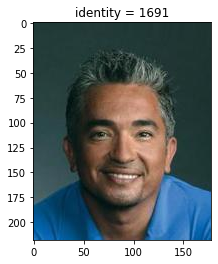

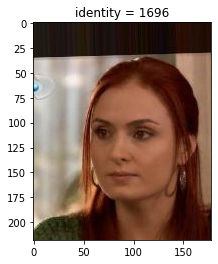

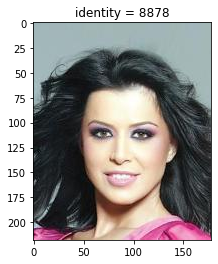

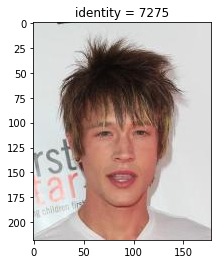

In [7]:
import matplotlib.pyplot as plt 
face_dataset = FaceDataset(root_dir='large_prepared_data/test') 

for idx in range(4): 
  _, identity, img = face_dataset[idx]  
  plt.title(f'identity = {identity}')
  plt.imshow(img)
  plt.show()

# Part 1: Face verification with contrastive loss

The objective of the face verification task is to validate whether the face image $x$ has the identity $y$ by comparing it to the face database of the claimed identity. If the face similarity score between $x$ and the face in the database of $y$ is above a certain threshold, the image is then verified; otherwise, the identity is rejected. 

In HW3, you have learned to calculate a similarity score based on compact image representation using a PCA / Fisher projection. Therefore, in this part, you will instead implement a more contemporary method by training the NN to propose a compact representation (feature vector) by using a Siamese network and contrastive loss (Chopra et al., 2005, http://yann.lecun.com/exdb/publis/pdf/chopra-05.pdf).

In contrast to the classification task that forces the model to learn all possible classes of objects, the general idea of object verification is based on contrastive learning, a framework that teaches the model to distinguish the two objects from each other. For a contrastive loss, the model will receive a pair of image and then learn to recognize whether both of them has the same identity by encouraging the feature vector of the same identity to come closer and different one to move away from each other. 

## 1.1 (TODO) Dataset and DataLoader 

First, we will start by writing a dataloader. The contrastive loss learns whether a pair of images have the same identity. Therefore, in this subsection, you have to write a dataloader that returns the tuple `(img1, img2, is_same_identity (bool))`.

**File structure of this dataset** 
```
- large_prepared_data/ 
└───train/
|    - {img1}.jpg
|    - {img2}.jpg
|    - label_df.csv
└───val/
|    - {img3}.jpg
|    - {img4}.jpg
|    - label_df.csv
└───test/
    - {img5}.jpg
    - {img6}.jpg
    - label_df.csv
```
**Note**

label_df.csv has 2 columns that are the filename such as 001257.jpg and the identity such as 1691


**Instructions**

TODO 1-4: Fill in the missing code in the cells below. \
TODO 1-2: Organize the dataset for simple data access. \
TODO 3: Randomly select the datapoint from the dataset and format it to be ready for training. \
TODO 4: Initialize the dataloader.

In [8]:
from pandas.core.algorithms import unique
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
      '''
        The dataset of siamese network
        [Args]
        - root_dir = root directory of the dataset 
        - transform = transformations for images 
      ''' 
      np.random.seed(123)
      random.seed(123)
      self.root_dir = root_dir
      self.transform = transform

      label_df = pd.read_csv(f'{root_dir}/label_df.csv')
      self.num_images = len(label_df)
      label_df = label_df.groupby('identity')['filename'].apply(list).reset_index().rename({'filename': 'filenames'}, axis=1)
      self.load_images_to_memory_(label_df) 
        
    def load_images_to_memory_(self, label_df): 
      '''
        Load all images into memory 
        [Args]
        - label_df = The dataframe containing the identities and the filenames of images  
      '''
      # TODO 1: load images to `self.data` according to the structure below.
      # Convert images to RGB as well
      #   self.data = {
      #   'identity1': [image1, image2], 
      #   'identity2': [image3, image4, image5], 
      # }
      # identity{i}: str, image{i}: PIL.Image
      
      self.data = { identityId: [Image.open(f"{self.root_dir}/{filename}").convert('RGB') \
                  for filename in label_df[label_df['identity']==identityId]['filenames'].to_list()[0]] \
                  for identityId in label_df['identity']}

      self.images = {}

      self.identities = label_df['identity']
      
      # TODO 2: save the list of identities found in self.identities (the keys)
      # in `self.unique_identities` as a numpy array.
      self.unique_identities = np.unique(self.identities)

    def __len__(self):
      return self.num_images 
        
    def __getitem__(self, idx): 
      '''
      Return a pair of image together with its label 
      [Args]
      - idx: int 
      [Return]
      - img1: torch.FloatTensor 
      - img2: torch.FloatTensor 
      - label: totch.FloatTensor = 1 (same class), 0 (different class)
      '''
      # TODO 3: randomly sample a pair of images 
      # Note: if idx is even, it should return the same class pair, otherwise a random pair.
      # Please use label = 1 for the same class pairs and label = 0 for the different class pairs
      idt_list = list(self.data.keys())
      idt1 = np.random.choice(idt_list)
      idt2 = np.random.choice(idt_list)
      data_idt1_list = self.data[idt1]
      data_idt2_list = self.data[idt2]
      img1 = self.transform(np.random.choice(data_idt1_list))
      img2 = self.transform(np.random.choice(data_idt1_list)) if idx%2==0 else self.transform(np.random.choice(data_idt2_list))
      label = idt1==idt1 if idx%2==0 else idt1==idt2
      return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))

In [9]:
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

train_batch_size = 32
val_batch_size = 32
test_batch_size = 32 

# TODO 4: declare the datasets and the dataloaders. We already split the data
# for you in the zip file. Look at the directory names.
train_siamese_dataset = SiameseDataset('large_prepared_data/train', train_transform)  
train_siamese_dataloader = DataLoader(train_siamese_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True) 

val_siamese_dataset = SiameseDataset('large_prepared_data/val', val_transform)  
val_siamese_dataloader = DataLoader(val_siamese_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)  

test_siamese_dataset = SiameseDataset('large_prepared_data/test', val_transform)  
test_siamese_dataloader = DataLoader(test_siamese_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)  

## 1.2 (TODO) Siamese network 

After the dataloader is initialized, we then build a siamese network. Section 1.5 will explain how a siamese network works in full detail.

Siamese network is a typical CNN that consists of three modules:

1. A feature extractor (ResNet18) for extracting the feature map from an image.
2. A global pooling for reducing the image dimension.
3. A fully connected layer for compressing the feature vector 

Every fully connected layer is followed by ReLU activations. 


TODO 5: Implement a siamese network based on the description.

**Note**
1. You can use the ResNet18 from the `torchvision` library (How to use torchvision: https://pytorch.org/vision/stable/models.html)
2. We will not use pretrained weights. 



Figure 1 Siamese network 

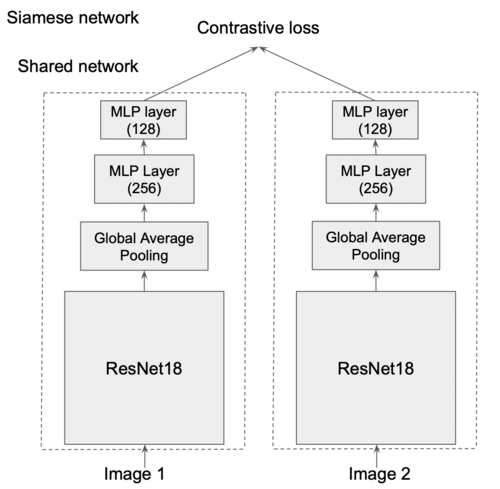

In [10]:
class SiameseNetwork(nn.Module):
  # TODO 5: implement the siamese network 
  def __init__(self):
      super().__init__()
      self.resnet = models.resnet18()
      self.GAP = nn.AdaptiveAvgPool1d(512)
      self.MLP1 = nn.Linear(512, 256)
      self.MLP2 = nn.Linear(256, 128)

  def extract_feature(self, x):
      output = self.resnet(x) 
      output = self.GAP(output)
      output = F.relu(self.MLP1(output))
      output = F.relu(self.MLP2(output))
      return output

  def forward(self, input1, input2):
      output1 = self.extract_feature(input1) 
      output2 = self.extract_feature(input2)  
      return output1, output2

In [11]:
siamese_model = SiameseNetwork()
summary(siamese_model, [(1, 3, 224, 224), (1, 3, 224, 224)])

Layer (type:depth-idx)                        Output Shape              Param #
SiameseNetwork                                --                        --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           73,984
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]          295,42

## 1.3 (TODO) Constrastive loss 
A contrastive loss is a loss used to minimize the dissimilarity between two images by encouraging the feature vector of the same identity to come closer and different one further than a constant margin $m$ to move away from each other. 


The contrastive loss is mathematically defined as: 


$
L\ (contrastive\ loss ) = \begin{cases} 
                        d(r_1, r_2) & if\ identity(r1) = identity(r2) \\ 
                        max(0, m - d(r_1, r_2)) & if\ identity(r1) \neq identity(r2) \\
                    \end{cases}
\
$

where 

- $d(r_1, r_2)$ = euclidean distance between $r_1$ and $r_2$  
- $m$ = margin 
- $identity(x)$ = the identity of x 
- $r_1$ = the feature vector of the first image
- $r_2$ = the feature vector of the second image


The term $d(r_1, r_2)$ is the distance between the two feature vectors. The contrastive loss minimizes the distance between the feature vectors of the same identity (positive pair) but maximizes the distance of the different identities (negative pair).

The margin $m$ is used to prevent the loss from collapsing to a trivial solution. For instance, when $m = 0$, the model could achieve $L = 0$ just by exploiting the objective by setting $r_1 = r_2$, and the model, as a result, would learn nothing useful.

**HINT**

Many torch functions often have the same functionality as NumPy functions, even sharing the same function name. Therefore, if you are struggling with this part, you might write the loss using NumPy first and then convert it to the torch function (https://pytorch.org/docs/stable/torch.html) later.
**Avoid using "if statements" to make the training faster. You have already learned many tricks that convert if statements into a single equation.**

TODO 6: Implement a contrastive loss based on the description above.

In [12]:
class ContrastiveLoss(torch.nn.Module):
  # TODO 6: implement the contrastive loss 
  def __init__(self, margin):
    super().__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    distance = F.pairwise_distance(output1, output2, keepdim=True) 
    loss_contrastive = torch.mean(label*distance + (1-label)*(torch.clamp(self.margin-distance, min=0)))
    return loss_contrastive

In [13]:
siamese_margin = 2.0
siamese_criterion = ContrastiveLoss(margin=siamese_margin)

## 1.4 Initiaze model parameter

In [14]:
siamese_optimizer = optim.Adam(siamese_model.parameters(), lr=1e-4)
siamese_scheduler = optim.lr_scheduler.ReduceLROnPlateau(siamese_optimizer, 'min', patience=5, factor=0.1, min_lr=1e-8) 

## 1.5 (TODO) Training loop 

The training procedure of a siamese network consists of the following steps:

1. Forward pass the `img1`.
2. Forward pass the `img2`.
3. Calculate the distance between the feature vector of `img1` and `img2` $(d(r_1, r_2))$.
4. Use the distance in step 3 as a loss and update the model.
5. Repeat step 1-4 until satisfied.

As you would notice, both first and second step shares the same network weights. Therefore, the word "Siamese" in the siamese network originates from the "Siamese twins" since the network performs two forward passes to compare whether the feature vectors have the same identity by using the same set of network parameters (shared parameters). 

TODO 7-8: Feed pairs of images to the network, compute contrastive loss to measure the dissimilarity of pairs of face images and update the network.

TODO 9: Feed a pair of images from validation set to the network and compute the validation loss.

**Trivia**

The Siamese twin is a conjoined twin brother born in Siam who later move to the US (https://th.wikipedia.org/wiki/%E0%B8%AD%E0%B8%B4%E0%B8%99-%E0%B8%88%E0%B8%B1%E0%B8%99).

In [136]:
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
siamese_model.to(device)

os.makedirs('weights', exist_ok=True)
best_weights_path = 'weights/best_siamese_weights.pth' 

train_losses = [] 
val_losses = [] 
min_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)): 
    siamese_model.train() 
    total_train_loss = 0 
      
    
    for img1, img2, label in train_siamese_dataloader:
        # TODO 7: feed data to model and compute loss 
        siamese_optimizer.zero_grad()
        img1 = img1.to(device); img2 = img2.to(device); label = label.to(device)
        out1, out2 = siamese_model(img1, img2)
        train_loss = siamese_criterion(out1, out2, label)

        # TODO 8: back propagate
        train_loss.backward()
        siamese_optimizer.step()

        total_train_loss += train_loss.item()


    current_train_loss = total_train_loss / len(train_siamese_dataloader) 
    train_losses.append(current_train_loss) 
            
    total_val_loss = 0 
    siamese_model.eval() 
    with torch.no_grad():
        for val_img1, val_img2, val_label in val_siamese_dataloader:  

            # TODO 9: feed data to model and compute loss 
            val_img1 = val_img1.cuda(); val_img2 = val_img2.cuda(); val_label = val_label.cuda()
            out1, out2 = siamese_model(val_img1, val_img2)
            val_loss = siamese_criterion(out1, out2, val_label)

            total_val_loss += val_loss.item()
    current_val_loss = total_val_loss / len(val_siamese_dataloader)
    val_losses.append(current_val_loss) 
    if current_val_loss < min_val_loss: 
        min_val_loss = current_val_loss 
        torch.save(siamese_model.state_dict(), best_weights_path)
    print(f'Epoch {epoch+1} - Train loss = {current_train_loss:.4f} - Val loss = {current_val_loss:.4f} - best min_val_loss = {min_val_loss:.4f} - lr = {siamese_optimizer.param_groups[0]["lr"]:.8f}') 
    siamese_scheduler.step(current_val_loss)


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_11784/3567807644.py:67: FutureWarning:

The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_11784/3567807644.py:67: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_11784/3567807644.py:68: FutureWarning:

The input object of type 'Image' is an array-like im

Epoch 1 - Train loss = 0.9040 - Val loss = 0.8502 - best min_val_loss = 0.8502 - lr = 0.00010000
Epoch 2 - Train loss = 0.8276 - Val loss = 0.7199 - best min_val_loss = 0.7199 - lr = 0.00010000
Epoch 3 - Train loss = 0.7708 - Val loss = 0.6891 - best min_val_loss = 0.6891 - lr = 0.00010000
Epoch 4 - Train loss = 0.7664 - Val loss = 0.8123 - best min_val_loss = 0.6891 - lr = 0.00010000
Epoch 5 - Train loss = 0.7356 - Val loss = 0.7685 - best min_val_loss = 0.6891 - lr = 0.00010000
Epoch 6 - Train loss = 0.7833 - Val loss = 0.7910 - best min_val_loss = 0.6891 - lr = 0.00010000
Epoch 7 - Train loss = 0.7956 - Val loss = 0.8116 - best min_val_loss = 0.6891 - lr = 0.00010000
Epoch 8 - Train loss = 0.7805 - Val loss = 0.7038 - best min_val_loss = 0.6891 - lr = 0.00010000
Epoch 9 - Train loss = 0.7311 - Val loss = 0.6588 - best min_val_loss = 0.6588 - lr = 0.00010000
Epoch 10 - Train loss = 0.7581 - Val loss = 0.6233 - best min_val_loss = 0.6233 - lr = 0.00010000
Epoch 11 - Train loss = 0.759

## 1.6 Visualization 

This visualization displays pairs of images together with the distance between those pairs. 

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_11784/3567807644.py:67: FutureWarning:

The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_11784/3567807644.py:67: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_11784/3567807644.py:68: FutureWarning:

The input object of type 'Image' is an array-like im

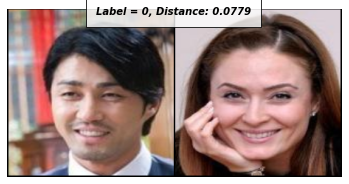

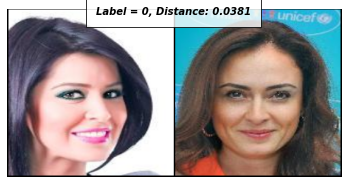

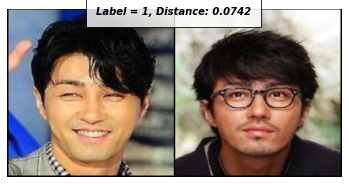

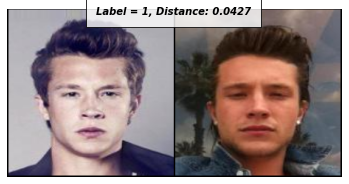

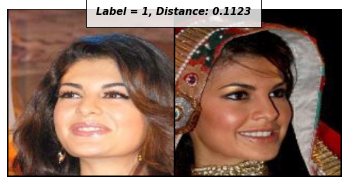

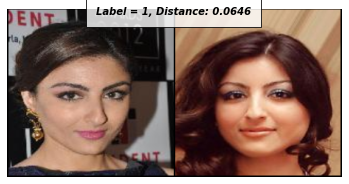

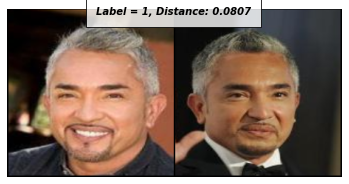

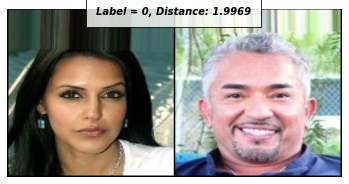

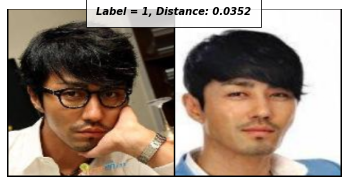

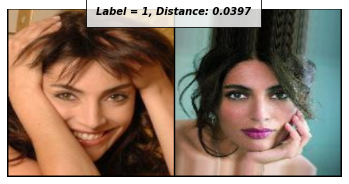

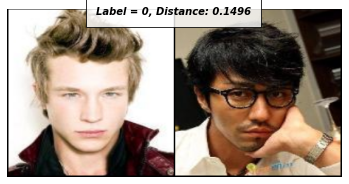

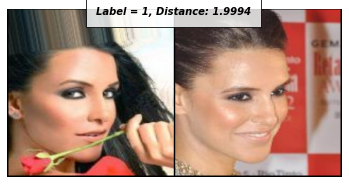

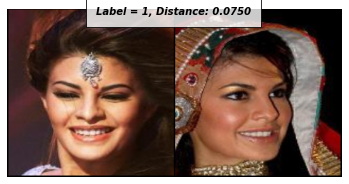

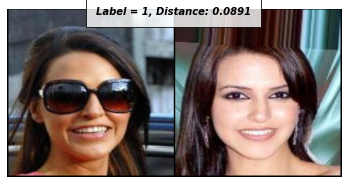

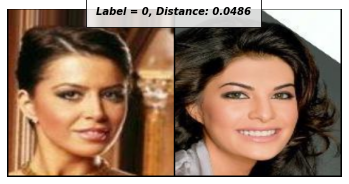

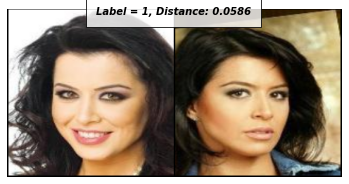

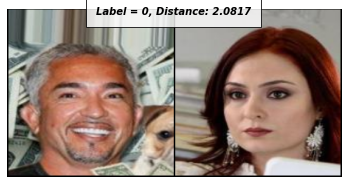

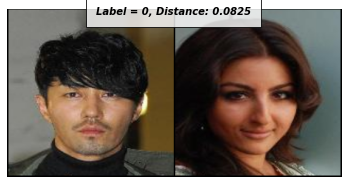

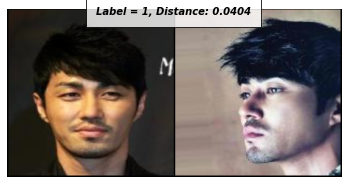

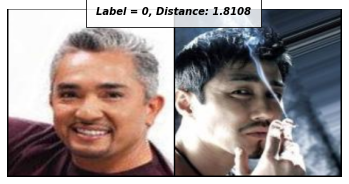

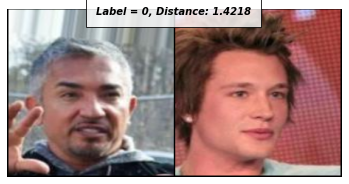

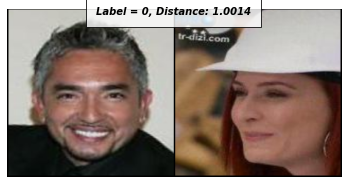

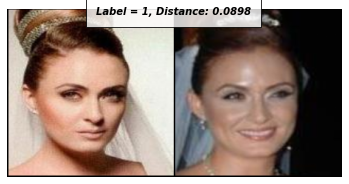

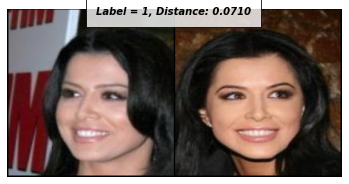

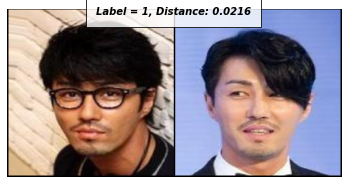

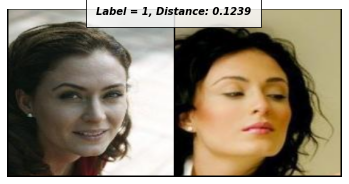

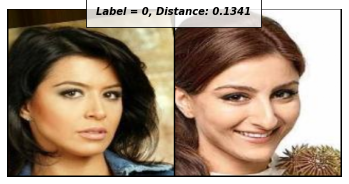

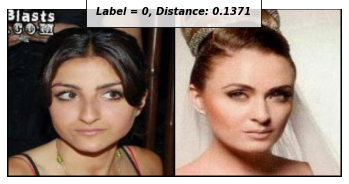

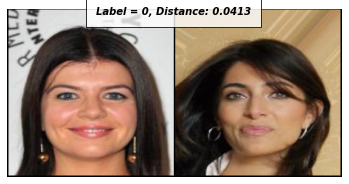

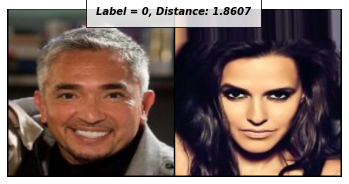

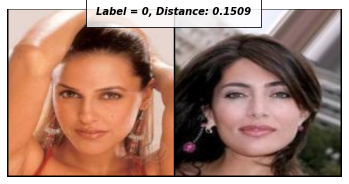

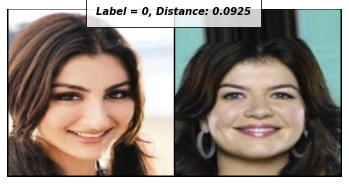

In [137]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(120, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    


siamese_model.load_state_dict(torch.load(best_weights_path))
siamese_model.eval() 

test_img1s, test_img2s, test_labels = next(iter(test_siamese_dataloader))
test_img1s, test_img2s, test_labels = test_img1s.to(device), test_img2s.to(device), test_labels.to(device)
with torch.no_grad(): 
    test_out1s, test_out2s = siamese_model(test_img1s, test_img2s)  

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalizer = UnNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
      
for test_out1, test_out2, test_img1, test_img2, test_label in zip(test_out1s, test_out2s, test_img1s, test_img2s, test_labels):  
    test_img1 = unnormalizer(test_img1.detach().cpu().unsqueeze(0))
    test_img2 = unnormalizer(test_img2.detach().cpu().unsqueeze(0))
    concatenated = torch.cat((test_img1, test_img2), 0)
    distance = F.pairwise_distance(test_out1, test_out2) 
    imshow(torchvision.utils.make_grid(concatenated), f'Label = {int(test_label[0])}, Distance: {distance.item():.4f}')

## 1.7 Plot loss history 

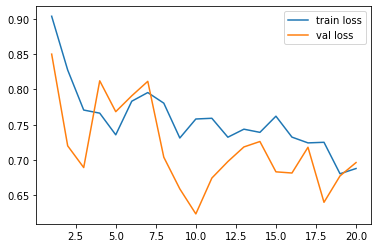

In [138]:
plt.plot(np.arange(1, len(train_losses)+1), train_losses, label='train loss') 
plt.plot(np.arange(1, len(val_losses)+1), val_losses, label='val loss') 
plt.legend()
plt.show()

## 1.8 (TODO) Plot t-SNE  

After the training process is finished, we evaluate whether the learned representation is informative. In this task, embedding visualization is often performed to verify that the feature learned by the network is behaving as intended, i.e., feature vectors of the same identity should be close to each other and far away from other identities. Since the feature vector dimension is too high for a human to interpret, therefore, in this assignment, we use the t-SNE dimensionality reduction technique to compress the feature into a 2D space.


**Instructions**

TODO 10: Extract the feature vectors of the test set and store them as 

`embeddings`: torch.FloatTensor = feature vectors of all images in the test set

`identities`: list or torch.Tensor or np.array = identities of all images in the test set 

**Hint**      
Use `FaceDataset` that is imported at `Common Dataset` section 

**WARNING!!**
Don't forget load its best weights and change to eval mode first 

In [139]:
test_batch_size = 32 

# TODO 10: Extract the feature vectors of the test set and store them as 
# `embeddings`: torch.FloatTensor = feature vectors of all images in the test set
# `identities`: list or torch.Tensor or np.array = identities of all images in the test set 
# Hint      => Use `FaceDataset` that is imported at `Common Dataset` section 
# WARNING!! => Don't forget load its best weights and change to eval mode first 
embeddings = [] 
identities = []

siamese_model.load_state_dict(torch.load(best_weights_path))
siamese_model.eval()

for idx in range(len(face_dataset)): 
    _, identity, test_img1s = face_dataset[idx]
    test_img1s = torch.reshape(val_transform(Image.fromarray(test_img1s)), (1, 3, 224, 224))
    test_img2s = torch.ones_like(test_img1s)
    test_labels = torch.FloatTensor(0)
    test_img1s, test_img2s, test_labels = test_img1s.to(device), test_img2s.to(device), test_labels.to(device)
    with torch.no_grad(): 
        test_out1s, test_out2s = siamese_model(test_img1s, test_img2s) 
        embeddings.append(test_out1s)
        identities.append(identity)
embeddings = torch.stack(embeddings).view(301,128).cpu()

In [140]:
import time 
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(embeddings, identities)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\PoraRee\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\PoraRee\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.001s...
[t-SNE] Computed neighbors for 301 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 0.020176
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.882767
[t-SNE] KL divergence after 1350 iterations: 0.422967
t-SNE done! Time elapsed: 1.4929993152618408 seconds


In [141]:
import plotly.express as px

# relabel to be easier to see in t-SNE visualization 
label = [] 
idx = 0 
id2label = dict() 
for identity in identities: 
  identity = int(identity) 
  if identity not in id2label:
    id2label[identity] = idx 
    idx += 1 
  label.append(id2label[identity])

df_subset = pd.DataFrame({'label': label})

df_subset['tsne-2d-one'] = tsne_result[:,0]
df_subset['tsne-2d-two'] = tsne_result[:,1]

fig = px.scatter(df_subset, x="tsne-2d-one", y="tsne-2d-two", color="label", height=1000, width=1000)
fig.show()

## 1.9 (TODO) Analyzing feature vector visualization result 

TODO 11: What could you say about the displayed visualization? Is the model working as expected?

Answer here: ไม่ เพราะการเกาะกลุ่มของข้อมูลมีเพียงสีเดียว หมายความว่าโมเดลสามารถแยกความแตกต่างได้แพียงคนเดียว

# Part 2: Face verification with triplet loss + center loss 


In contrast to contrastive loss which learns to distinguish whether the two images have the same identity, triplet loss is proposed as an alternative by introducing an anchor image as a third input. Triplet loss receives three inputs: anchor, positive pair, and negative pair. The positive pair is an image having the same identity as the anchor while the negative pair is the one with a different identity. The loss learns to minimize the distance between the anchor and positive pair, and maximize the distance between the anchor and the negative pair. Compared to contrastive loss, triplet loss offers more training stability and better model performance.

Nevertheless, both contrastive and triplet loss also has some shortcomings as these losses only optimize on a pairwise level. This might result in feature vectors of the same identity taking the form of multiple small clusters scattering across the feature space since there is no explicit loss to bind them into a single group. Therefore, a center loss is proposed to mitigate this problem by encouraging the intra-class (same identity) feature vectors to come closer to their intra-class centroids.

In this part, you are going to implement a face verification network by jointly training **three losses**: triplet, center, and cross-entropy loss.


## 2.1 (TODO) Dataset and DataLoader 

In this section, you are going to implement a dataloader for the combined loss. 
The dataloader should return the tuple `(anchor_img, pos_img, neg_img, anchor_label, pos_label, neg_label)`. 

TODO 12-15: Fill in the missing code in the cells below. \
TODO 12-13: Organize the dataset for simple data access. \
TODO 14: Randomly select the datapoint from the dataset and format it to be ready for training. 
- The positive image must have the same identity as the anchor image.
- The negative image must have a different identity from the anchor image. \
- HINT: The NumPy function `np.where` might be useful.

TODO 15: Initialize the dataloader.

In [35]:
# label_df = pd.read_csv(f'large_prepared_data/test/label_df.csv')
# label_df = label_df.groupby('identity')['filename'].apply(list).reset_index().rename({'filename': 'filenames'}, axis=1)
# label_df

In [36]:
# images = np.sum([filenames for filenames in label_df['filenames']], dtype=object)
# images = [Image.open(f"large_prepared_data/test/{filename}").convert('RGB') for filename in images]
# images[:5]

In [37]:
# labels = np.sum([([idx]*len(data[1])) for idx, data in enumerate(label_df.values)], dtype=object)
# labels[4]

In [38]:
# label2indices = {k:[] for k in np.arange(len(label_df['identity'].unique()))}
# for idx, key in enumerate(labels):
#     label2indices[key]+=[idx]
# label2indices[2][:6]

In [15]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
      np.random.seed(123)
      random.seed(123)
      self.root_dir = root_dir
      self.transform = transform
      
      label_df = pd.read_csv(f'{root_dir}/label_df.csv')
      label_df = label_df.groupby('identity')['filename'].apply(list).reset_index().rename({'filename': 'filenames'}, axis=1)
      self.images = [] 
      self.labels = [] 
      self.label2indices = dict() 
      self.load_images_to_memory_(label_df) 
      
    def load_images_to_memory_(self, label_df):  
      # TODO 12: load images and labels into memory  
      # We have to relabel from identities to 0,1,2,...,num_classes-1
      # Relevant variables 
      # 1. `self.images` = PIL images  (Also convert it to RGB)
      # 2. `self.label2indices` = the dictionary storing a label as a key and the indices of images as value 
      # 3. `self.labels` = labels of images (relabeled) 
      # Note: the index of images is from iterating over label_df
      self.images = np.sum([filenames for filenames in label_df['filenames']], dtype=object)
      self.images = [Image.open(f"{self.root_dir}/{filename}").convert('RGB') for filename in self.images]
      
      self.labels = np.sum([([idx]*len(data[1])) for idx, data in enumerate(label_df.values)], dtype=object) 
       
      self.label2indices = {k:[] for k in np.arange(len(label_df['identity'].unique()))}
      for idx, key in enumerate(self.labels):
          self.label2indices[key].append(idx) 
     

    def __len__(self):
      return len(self.images) 
        
    def __getitem__(self, idx): 
      # TODO 13: generate an anchor image, a positive image and a negative image together with anchor_label 
      # anchor image is the image according to idx 
      # positive image is the image that has the same identity with the anchor image 
      # negative image is the image that has the different identity with the anchor image 
      anchor_img = self.images[idx]
      
      anchor_label = self.labels[idx]
      pos_label = anchor_label
      neg_label = np.random.choice(list(self.label2indices.keys()))
      while neg_label==anchor_label:
          neg_label = np.random.choice(list(self.label2indices.keys()))
          
      pos_img = self.images[np.random.choice(self.label2indices[pos_label])] 
      neg_img = self.images[np.random.choice(self.label2indices[neg_label])]  


      # TODO 14: utilize `self.transform' to convert images to tensors 
      anchor_img = self.transform(anchor_img)
      pos_img = self.transform(pos_img)
      neg_img = self.transform(neg_img)
      

      return anchor_img, pos_img, neg_img, anchor_label, pos_label, neg_label


In [16]:
image_size = 224
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

train_batch_size = 16
val_batch_size = 16
test_batch_size = 16

# TODO 15: declare the datasets and the dataloaders 
train_triplet_dataset = TripletDataset('large_prepared_data/train', train_transform) 
train_triplet_dataloader = DataLoader(train_triplet_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)  

val_triplet_dataset = TripletDataset('large_prepared_data/val', val_transform)  
val_triplet_dataloader = DataLoader(val_triplet_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)   

test_triplet_dataset = TripletDataset('large_prepared_data/test', val_transform)  
test_triplet_dataloader = DataLoader(test_triplet_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)   

C:\Users\PoraRee\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## 2.2 (TODO) Triplet Network 

Triplet network is a simplified version of a strong baseline person re-identification task (ref: https://arxiv.org/abs/1903.07071). The model uses the extracted features to calculate the main triplet loss with center loss to reduce intra-class distance and a classification output head to calculate a classification loss.

Triplet network consists of three modules
1. Feature extractor (ResNet18) for mapping an image to a feature map.   
2. Global pooling (Global average pooling or use flatten instead) for converting a feature map to a feature vector.
3. Bottleneck (Batch normalization with scaling shift only, no bias shift) for training consistency between triplet loss and cross-entropy as optimizing both losses in embedding space at the same time is difficult. 
4. Linear classifier for classifying the face identity. 

As illustration of a triplet net is shown below

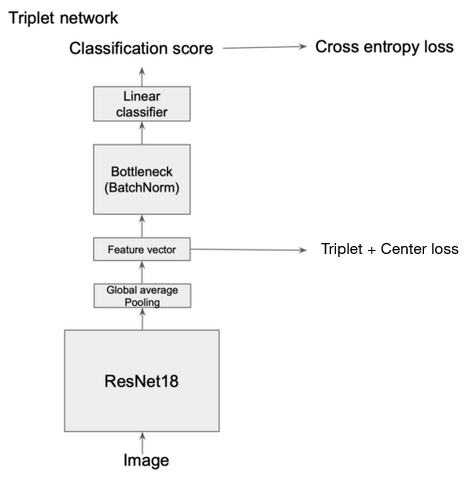

**Note**
1. ResNet18 can be called via the `torchvision` library (How to use torchvision: https://pytorch.org/vision/stable/models.html)
2. We use will not load pre-trained weights for ResNet18
3. We will only use ResNet18 to extract feature maps. 

**Hint**
1. For global average pooling, read the documentation of `nn.AdaptiveAvgPool2d` 
2. For bottleneck, try the `requires_grad_` method to stop calculating gradient for the bias shift.


TODO 16-17: Implement the triplet network.

In [17]:
class TripletNetwork(nn.Module):
  # TODO 16: implement the triplet network 
  def __init__(self, num_classes):
    super().__init__()
    self.num_classes = num_classes
    self.resnet = models.resnet18()
    self.GAP = nn.AdaptiveAvgPool1d(512)
    self.Norm = nn.BatchNorm1d(512)
    self.MLP = nn.Linear(512, num_classes)
    self.Softmax = nn.Softmax(dim=1)

  def extract_feature(self, x):
    output = self.resnet(x)
    output = self.GAP(output)
    global_feat = output
    
    output = self.Norm(output)
    output = self.MLP(output)
    output = self.Softmax(output)
    cls_score = output
    
    return global_feat, cls_score

  def forward(self, anchor_img, pos_img, neg_img): 
    anchor_feat, anchor_score = self.extract_feature(anchor_img) 
    pos_feat, pos_score = self.extract_feature(pos_img)
    neg_feat, neg_score = self.extract_feature(neg_img)
    feats = [anchor_feat, pos_feat, neg_feat]
    scores = [anchor_score, pos_score, neg_score]
    return anchor_feat, pos_feat, neg_feat, feats, scores 

In [18]:
# TODO 17: get the number of classes to construct a linear classifier and the parameters in center loss 
num_classes = train_triplet_dataset.labels[-1] + 1 
print(f'num_classes = {num_classes}') 

triplet_model = TripletNetwork(num_classes) 

num_classes = 80


## 2.3 (TODO) Triplet loss 

Triplet loss uses the same concept as contrastive loss that is the anchor image will pull the positive one closer and push the negative one further than the constant margin away. Hence, we have sampled three images to compute it.
The three images consist of:
1. an anchor image = an initial image
2. a positive image = the image having the same identity as the anchor image 
3. a negative image = the image having a different identity from the anchor image 

The triplet loss is mathematically defined as:

$L_{Triplet} = max(0, m + d(r_a, r_p) - d(r_a, r_n))$ 

where 
- $d(r_1, r_2)$ = euclidean distance between $r_1$ and $r_2$ 
- $m$ = margin
- $r_a$ = the feature vector of the anchor image
- $r_p$ = the feature vector of the positive image
- $r_n$ = the feature vector of the negative image 

The loss aims to minimize $d(r_a, r_p)$ while maximizing $d(r_a, r_n)$ at the same time. 

The margin $m$ is used to prevent the loss from collapsing to a trivial solution. For instance, when $m = 0$, the model could achieve $L = 0$ just by exploiting the objective by setting $r_a = r_p = r_n$, and the model, as a result, would learn nothing useful.

TODDO 18: Implement the triplet loss


In [19]:
class TripletLoss(nn.Module):
  # TODO 18: implement the triplet loss 
  def __init__(self, margin=2.0):  
    super().__init__()
    self.margin = margin
      
  def forward(self, anchor_img, pos_img, neg_img):
    pos_distance = F.pairwise_distance(anchor_img, pos_img, keepdim=True) 
    neg_distance = F.pairwise_distance(anchor_img, neg_img, keepdim=True) 
    loss_triplet = torch.mean(torch.clamp(self.margin + pos_distance - neg_distance, min=0))
    return loss_triplet

In [20]:
triplet_margin = 3.0
triplet_criterion = TripletLoss(margin=triplet_margin)

## 2.4 (TODO) Center loss
Reference: https://ydwen.github.io/papers/WenECCV16.pdf

**Definition** 

Centroid: a representative of each class. There are several ways to select a representative, one way to do this is to take an average on those embeddings. 

**Concept**

Center loss enforces the intra-class feature vectors to come closer to the centroid of their class so that all feature vectors of the same identity are clustered around a single centroid. Since the model is updated after each iteration, the centroids should also be updated accordingly. However, re-calculating the centroids by averaging the feature vectors for each class every iteration is computational-extensive on a large scale. Therefore, the centroid is instead learned from the representative of each class from the sampled data.

**Implementation detail**

In `__init__` method
  1. For simplicity, we will store the centroids in the class `CenterLoss`. Therefore, you have to initialize the centroids as a random tensor with the size of `(num_classes, feature_dimension)`. The tensor has to be set with `nn.Paramater` so that the gradient could be calculated (ref: https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html).

In the `forward` method 
  1. Calculate the distance between the feature vector and its center with a squared Euclidean distance 
  2. Clip the value in each element to be not greater than 1e+12, not lower than 1e-12, and sum them  
  3. Normalize the loss with its batch size 

**Center loss equation**

$L_{Center} = \frac{1}{B}\sum_{j=1}^{B}||f_{j} - c_{y_j}||_2^2$

where
- $f_{j}$ = a feature vector before fed into the bottleneck at index $j$
- $c_{y_j}$ = a center of the class corresponded to the index $j$
- B = batch size 

The center loss minimized the distance between the feature vector and the centroid of the corresponded identity.

**Note**
1. At `__init__` method in step 1. Do not forget to transfer the parameters to GPU with `.cuda()` otherwise, it will not utilize GPU on this part.
2. Clip the magnitude of the loss at the final stage before updating both upper bound and lower bound to avoid vanishing / exploding gradients.

**Hint** 
1. In step 2 of the `forward` method, you should use `torch.clamp` (ref: https://pytorch.org/docs/stable/generated/torch.clamp.html) to clip the lower bound and the upper bound as you want. 

In [21]:
class CenterLoss(nn.Module): 
  # TODO 19: implement the center loss 
  def __init__(self, num_classes, feat_dim):  
    super().__init__()
    self.num_classes = num_classes
    self.feat_dim = feat_dim
    self.centroids = nn.Parameter(torch.rand(size=(num_classes, feat_dim)))
   
  def forward(self, x, labels):
    centroids = self.centroids[labels].cuda()
    loss_center = torch.mean(torch.clamp(torch.norm(x-centroids, keepdim=True)**2, min=1e-12, max=1e12))
    return loss_center

In [22]:
triplet_center_criterion = CenterLoss(num_classes, feat_dim=512)

## 2.5 (TODO) Declare cross entropy criterions, optimizers and scheduler

In [23]:
triplet_optimizer = optim.Adam(triplet_model.parameters(), lr=5e-5)
triplet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(triplet_optimizer, 'min', patience=4, factor=0.1, min_lr=1e-8) 

# TODO 20: declare cross entropy loss 
crossentropy_criterion = nn.CrossEntropyLoss() 

triplet_center_optimizer = optim.Adam(triplet_center_criterion.parameters(), lr=5e-2)
triplet_center_loss_weight = 5e-3

## 2.6 (TODO) Training loop 

The figure below shows how the center loss is updated in the original paper. $L_s$ $L_c$, $W$, $\theta_c$ and $c_j$ stand for classification loss, center loss, classification head's weight, CNN weight, and centroid of the class $j$, respectively. Line 6 shows how centroids are updated.

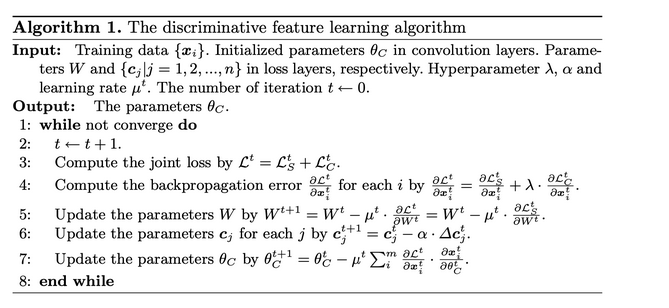

**Joint loss equation**

$L_{Joint} = L_{ID} + L_{Triplet} + \beta L_{Center}$ 

where
- $L_{Joint}$ = joint loss 
- $L_{ID}$ = identity loss (cross entropy loss in this implementation)
- $L_{Triplet}$ = triplet loss 
- $L_{Center}$ = center loss 
- $\beta$ = center loss weights (affects only the triplet network, not center update) 

The training procedure of the triplet network consists of the following steps: 

1. Forward pass the `anchor_img`
2. Forward pass the `positive_img`  
3. Forward pass the `negative_img` 
4. Calculate the distance between the feature vectors of `anchor_img`, `positive_img` and `negative_img` and calculate a triplet loss ($L_{Triplet}$).
5. Calculate the classification loss ($L_{ID}$).
6. Calculate the center loss ($L_{Center}$).
7. Scale the center loss with the predetermined weight ($\beta$) (only used to update the triplet network not to update the centroids).
8. Sum the losses from steps 4-7 and update the triplet network. (Line 3-5)
9. Rescale the gradients with $\frac{1}{\beta}$ at the loss in step 7 and update the centroids. (Line 6-7)
10. Repeat steps 1-9 till converge 

As you would notice, steps 1- 3 share the same model weight for feature extraction. Thus, the word "triplet" in triplet loss originates in a similar fashion as the "Siamese twins" but this loss function utilizes three feature vectors simultaneously instead of two. 



TODO 21 (step 1-4): extract feature vectors of three images and compute triplet loss 

TODO 22 (step 5): calculate cross-entropy loss from the output of the classification head. 

TODO 23 (step 6-7): compute the center loss by feeding both features and their labels and scale it with the center loss weights ($\beta$)

TODO 24 (step 8): set zero gradients at both optimizers 

TODO 25 (step 8): update the joint loss and step the triplet optimizer 

TODO 26 (step 9): rescale the gradients of centroids with $\frac{1}{\beta}$ and update the centroids with rescaled gradients 

TODO 27: feed anchor images, positive images, and negative images from the validation set to extract feature vectors and compute validation triplet loss 

**Hint**

1. At the gradient rescaling for the centroids, we should iterate parameters in center loss first with `.parameters()` and adjust the property of each parameter with `.grad.data` 



In [152]:
num_epochs = 20 
device = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs('weights', exist_ok=True)
best_weights_path = 'weights/best_triplet_weights.pth' 
triplet_model.to(device)
min_val_loss = float('inf')

train_losses = [] 
train_triplet_losses = [] 
train_crossentropy_losses = []  
train_center_losses = [] 

val_losses = [] 
val_triplet_losses = [] 

for epoch in tqdm(range(num_epochs)): 
    triplet_model.train() 
    total_train_loss = 0 
    total_train_triplet_loss = 0
    total_train_crossentropy_loss = 0
    total_train_center_loss = 0 
    for anchor_img, pos_img, neg_img, anchor_label, pos_label, neg_label in tqdm(train_triplet_dataloader):

        # TODO 21: feed data to the triplet model and compute triplet loss
        anchor_img, pos_img, neg_img = anchor_img.to(device), pos_img.to(device), neg_img.to(device)
        anchor_label, pos_label, neg_label = anchor_label.to(device), pos_label.to(device), neg_label.to(device)
        anchor_feat, pos_feat, neg_feat, feats, scores  = triplet_model(anchor_img, pos_img, neg_img)
        train_triplet_loss = triplet_criterion(anchor_feat, pos_feat, neg_feat)
        
        # TODO 22: compute cross entropy loss
        anchor_score_pred = scores[0]
        anchor_score_target = F.one_hot(anchor_label, num_classes=num_classes).type(dtype=torch.FloatTensor).cuda()
        train_crossentropy_loss = crossentropy_criterion(anchor_score_pred, anchor_score_target)
        
        # TODO 23: compute center loss 
        train_center_loss = triplet_center_criterion(anchor_feat, anchor_label)*triplet_center_loss_weight

        train_loss = train_triplet_loss + train_crossentropy_loss + train_center_loss
        total_train_loss += train_loss.item() 
        total_train_triplet_loss += train_triplet_loss.item()
        total_train_crossentropy_loss += train_crossentropy_loss.item()
        total_train_center_loss += train_center_loss.item()

        # TODO 24: set zero gradients at two optimizers 
        triplet_optimizer.zero_grad()
        triplet_center_optimizer.zero_grad()

        # TODO 25 : back propagate at triplet network and step the main optimizer 
        train_loss.backward() 
        triplet_optimizer.step()

        # TODO 26: rescale gradients of centers because `triplet_center_loss_weight` should not affect to learning the centers 
        # and step the center optimizer 
        triplet_center_criterion.centroids.grad /= triplet_center_loss_weight
        triplet_center_optimizer.step() 

    current_train_loss = total_train_loss / len(train_triplet_dataloader) 
    current_train_triplet_loss = total_train_triplet_loss / len(train_triplet_dataloader) 
    current_train_crossentropy_loss = total_train_crossentropy_loss / len(train_triplet_dataloader) 
    current_train_center_loss = total_train_center_loss / len(train_triplet_dataloader) 
    train_losses.append(current_train_loss)
    train_triplet_losses.append(current_train_triplet_loss)
    train_crossentropy_losses.append(current_train_crossentropy_loss) 
    train_center_losses.append(current_train_center_loss)            
            
    total_val_loss = 0 
    total_val_triplet_loss = 0 
    triplet_model.eval() 
    for val_anchor_img, val_pos_img, val_neg_img, _, _, _ in val_triplet_dataloader:  

      # TODO 27: feed data to the triplet model and compute triplet loss   
      val_anchor_img, val_pos_img, val_neg_img = val_anchor_img.to(device), val_pos_img.to(device), val_neg_img.to(device)
      val_anchor_feat, val_pos_feat, val_neg_feat, val_feats, val_scores  = triplet_model(val_anchor_img, val_pos_img, val_neg_img)
      val_triplet_loss = triplet_criterion(val_anchor_feat, val_pos_feat, val_neg_feat)
      
      val_loss = val_triplet_loss 
      total_val_loss += val_loss.item()
      total_val_triplet_loss += val_triplet_loss.item()
    current_val_loss = total_val_loss / len(val_triplet_dataloader)
    current_val_triplet_loss = total_val_triplet_loss / len(val_triplet_dataloader)
    val_losses.append(current_val_loss)
    val_triplet_losses.append(current_val_triplet_loss)
    
    if current_val_loss < min_val_loss: 
        min_val_loss = current_val_loss 
        torch.save(triplet_model.state_dict(), best_weights_path)
    print(f'Epoch {epoch+1} - Train loss = {current_train_loss:.4f} - Train triplet loss = {current_train_triplet_loss:.4f} - Train crossentropy loss = {current_train_crossentropy_loss:.4f}  - Train center loss = {current_train_center_loss:.4f} - Val loss = {current_val_loss:.4f} - Val triplet loss = {current_val_triplet_loss:.4f} - best min_val_loss = {min_val_loss:.4f} - lr = {triplet_optimizer.param_groups[0]["lr"]:.8f}') 
    triplet_scheduler.step(current_val_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 1 - Train loss = 8.4313 - Train triplet loss = 2.5191 - Train crossentropy loss = 4.3805  - Train center loss = 1.5317 - Val loss = 1.9637 - Val triplet loss = 1.9637 - best min_val_loss = 1.9637 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 2 - Train loss = 6.9410 - Train triplet loss = 2.1270 - Train crossentropy loss = 4.3718  - Train center loss = 0.4421 - Val loss = 1.7890 - Val triplet loss = 1.7890 - best min_val_loss = 1.7890 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 3 - Train loss = 6.8357 - Train triplet loss = 2.0187 - Train crossentropy loss = 4.3638  - Train center loss = 0.4531 - Val loss = 1.9720 - Val triplet loss = 1.9720 - best min_val_loss = 1.7890 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 4 - Train loss = 6.6804 - Train triplet loss = 1.7744 - Train crossentropy loss = 4.3527  - Train center loss = 0.5533 - Val loss = 1.5545 - Val triplet loss = 1.5545 - best min_val_loss = 1.5545 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 5 - Train loss = 6.4390 - Train triplet loss = 1.5236 - Train crossentropy loss = 4.3426  - Train center loss = 0.5729 - Val loss = 1.3850 - Val triplet loss = 1.3850 - best min_val_loss = 1.3850 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 6 - Train loss = 6.2560 - Train triplet loss = 1.3317 - Train crossentropy loss = 4.3268  - Train center loss = 0.5975 - Val loss = 1.3163 - Val triplet loss = 1.3163 - best min_val_loss = 1.3163 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 7 - Train loss = 6.1514 - Train triplet loss = 1.2858 - Train crossentropy loss = 4.3145  - Train center loss = 0.5511 - Val loss = 1.4090 - Val triplet loss = 1.4090 - best min_val_loss = 1.3163 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 8 - Train loss = 6.0484 - Train triplet loss = 1.2204 - Train crossentropy loss = 4.3045  - Train center loss = 0.5235 - Val loss = 1.1388 - Val triplet loss = 1.1388 - best min_val_loss = 1.1388 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 9 - Train loss = 5.8677 - Train triplet loss = 1.0735 - Train crossentropy loss = 4.2922  - Train center loss = 0.5021 - Val loss = 1.2147 - Val triplet loss = 1.2147 - best min_val_loss = 1.1388 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 10 - Train loss = 5.8656 - Train triplet loss = 1.0663 - Train crossentropy loss = 4.2788  - Train center loss = 0.5206 - Val loss = 1.0679 - Val triplet loss = 1.0679 - best min_val_loss = 1.0679 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 11 - Train loss = 5.7393 - Train triplet loss = 0.9665 - Train crossentropy loss = 4.2669  - Train center loss = 0.5059 - Val loss = 1.1107 - Val triplet loss = 1.1107 - best min_val_loss = 1.0679 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 12 - Train loss = 5.6685 - Train triplet loss = 0.9147 - Train crossentropy loss = 4.2568  - Train center loss = 0.4970 - Val loss = 1.1067 - Val triplet loss = 1.1067 - best min_val_loss = 1.0679 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 13 - Train loss = 5.6160 - Train triplet loss = 0.9047 - Train crossentropy loss = 4.2390  - Train center loss = 0.4723 - Val loss = 1.0136 - Val triplet loss = 1.0136 - best min_val_loss = 1.0136 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 14 - Train loss = 5.4895 - Train triplet loss = 0.7817 - Train crossentropy loss = 4.2297  - Train center loss = 0.4780 - Val loss = 1.1665 - Val triplet loss = 1.1665 - best min_val_loss = 1.0136 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 15 - Train loss = 5.5359 - Train triplet loss = 0.7900 - Train crossentropy loss = 4.2151  - Train center loss = 0.5308 - Val loss = 0.9795 - Val triplet loss = 0.9795 - best min_val_loss = 0.9795 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 16 - Train loss = 5.4097 - Train triplet loss = 0.7499 - Train crossentropy loss = 4.1927  - Train center loss = 0.4672 - Val loss = 1.0904 - Val triplet loss = 1.0904 - best min_val_loss = 0.9795 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 17 - Train loss = 5.3338 - Train triplet loss = 0.6748 - Train crossentropy loss = 4.1767  - Train center loss = 0.4824 - Val loss = 1.2279 - Val triplet loss = 1.2279 - best min_val_loss = 0.9795 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 18 - Train loss = 5.3718 - Train triplet loss = 0.6875 - Train crossentropy loss = 4.1659  - Train center loss = 0.5183 - Val loss = 1.0775 - Val triplet loss = 1.0775 - best min_val_loss = 0.9795 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 19 - Train loss = 5.2758 - Train triplet loss = 0.6438 - Train crossentropy loss = 4.1468  - Train center loss = 0.4851 - Val loss = 0.9448 - Val triplet loss = 0.9448 - best min_val_loss = 0.9448 - lr = 0.00005000


  0%|          | 0/153 [00:00<?, ?it/s]

Epoch 20 - Train loss = 5.2516 - Train triplet loss = 0.6384 - Train crossentropy loss = 4.1319  - Train center loss = 0.4813 - Val loss = 1.0116 - Val triplet loss = 1.0116 - best min_val_loss = 0.9448 - lr = 0.00005000


## 2.7 Visualization 

The visualization below displays an anchor, positive, and negative image and their respective distance.

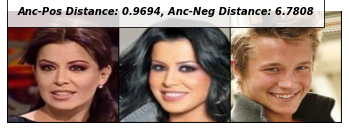

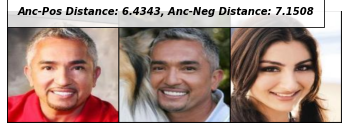

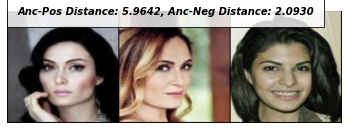

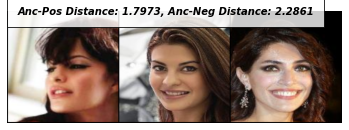

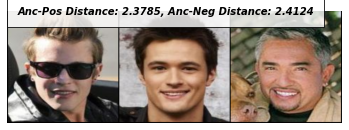

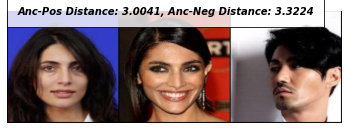

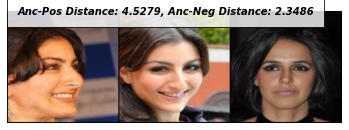

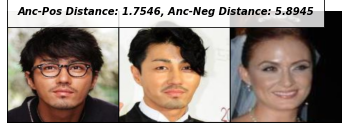

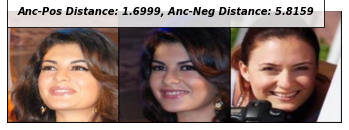

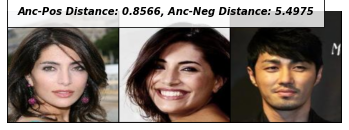

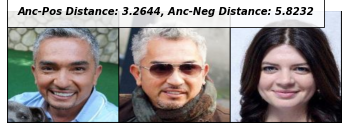

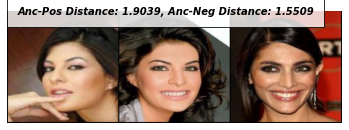

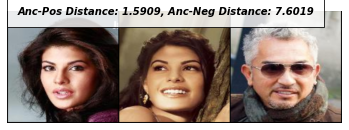

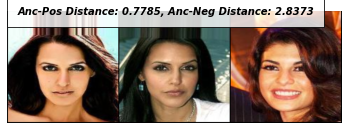

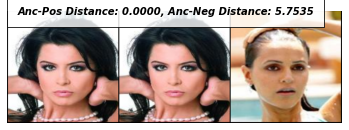

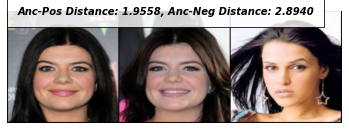

In [153]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(20, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

best_weights_path = 'weights/best_triplet_weights.pth' 
triplet_model.to(device)
triplet_model.load_state_dict(torch.load(best_weights_path))
triplet_model.eval() 

test_anchor_imgs, test_pos_imgs, test_neg_imgs, test_anchor_ids, _, _ = next(iter(test_triplet_dataloader))
test_anchor_imgs, test_pos_imgs, test_neg_imgs = test_anchor_imgs.to(device), test_pos_imgs.to(device), test_neg_imgs.to(device)
with torch.no_grad(): 
    test_anchor_feats, test_pos_feats, test_neg_feats, _, _ = triplet_model(test_anchor_imgs, test_pos_imgs, test_neg_imgs)  

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalizer = UnNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

zip_test_data = zip(test_anchor_feats, test_pos_feats, test_neg_feats, test_anchor_imgs, test_pos_imgs, test_neg_imgs)      
for test_anchor_feat, test_pos_feat, test_neg_feat, test_anchor_img, test_pos_img, test_neg_img in zip_test_data:  
    test_anchor_img = unnormalizer(test_anchor_img.detach().cpu().unsqueeze(0))
    test_pos_img = unnormalizer(test_pos_img.detach().cpu().unsqueeze(0))
    test_neg_img = unnormalizer(test_neg_img.detach().cpu().unsqueeze(0))
    concatenated = torch.cat((test_anchor_img, test_pos_img, test_neg_img), 0)
    anc_pos_distance = F.pairwise_distance(test_anchor_feat, test_pos_feat) 
    anc_neg_distance = F.pairwise_distance(test_anchor_feat, test_neg_feat) 
    imshow(torchvision.utils.make_grid(concatenated), f'Anc-Pos Distance: {anc_pos_distance.item():.4f}, Anc-Neg Distance: {anc_neg_distance.item():.4f}')

## 2.8 Plot loss history 

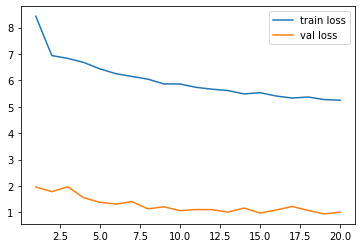

In [154]:
import matplotlib.pyplot as plt 
plt.plot(np.arange(1, len(train_losses)+1), train_losses, label='train loss') 
plt.plot(np.arange(1, len(val_losses)+1), val_losses, label='val loss') 
plt.legend()
plt.show()

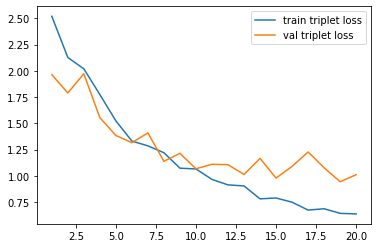

In [155]:
import matplotlib.pyplot as plt 
plt.plot(np.arange(1, len(train_losses)+1), train_triplet_losses, label='train triplet loss') 
plt.plot(np.arange(1, len(val_losses)+1), val_triplet_losses, label='val triplet loss') 
plt.legend()
plt.show()

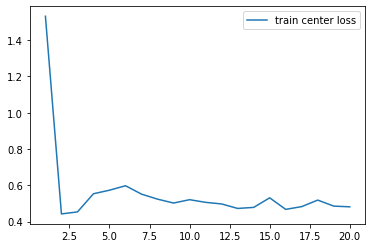

In [156]:
import matplotlib.pyplot as plt 
plt.plot(np.arange(1, len(train_losses)+1), train_center_losses, label='train center loss') 
plt.legend()
plt.show()

## 2.9 (TODO) Plot t-SNE

This section is similar to section 1.8 but the network is instead optimized using a combined triplet, center, and cross-entropy loss. 

**Instructions**

TODO 28: Extract the feature vectors of the test set and store them as 

`embeddings`: torch.FloatTensor = feature vectors of all images in the test set

`identities`: list or torch.Tensor or np.array = identities of all images in the test set 

**Hint**      
Use `FaceDataset` that is imported at `Common Dataset` section 

**WARNING!!**
Don't forget load its best weights and change to eval mode first 

In [157]:
test_batch_size = 32 

# TODO 28: Extract the feature vectors of the test set and store them as 
# `embeddings`: torch.FloatTensor = feature vectors of all images in the test set
# `identities`: list or torch.Tensor or np.array = identities of all images in the test set 
# Hint      => Use `FaceDataset` that is imported at `Common Dataset` section 
# WARNING!! => Don't forget load its best weights and change to eval mode first 

embeddings = [] 
identities = []

#face_dataset = FaceDataset(root_dir='large_prepared_data/test', transform = val_transform) 

triplet_model.load_state_dict(torch.load(best_weights_path))
triplet_model.eval() 

for idx in range(len(face_dataset)): 
    _, identity, test_img1s = face_dataset[idx]
    test_img1s = torch.reshape(val_transform(Image.fromarray(test_img1s)), (1, 3, 224, 224))
    test_img1s = test_img1s.to(device)
    with torch.no_grad(): 
        feat, sc = triplet_model.extract_feature(test_img1s)
        embeddings.append(feat)
        identities.append(identity)
embeddings = torch.stack(embeddings).view(301, 512).cpu()

In [158]:
import time 
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(embeddings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\PoraRee\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\PoraRee\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.001s...
[t-SNE] Computed neighbors for 301 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 0.815484
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.938904
[t-SNE] KL divergence after 1600 iterations: 0.421835
t-SNE done! Time elapsed: 1.2959914207458496 seconds


In [159]:
import plotly.express as px

label = [] 
idx = 0 
id2label = dict() 
for identity in identities: 
  identity = int(identity) 
  if identity not in id2label:
    id2label[identity] = idx 
    idx += 1 
  label.append(id2label[identity])

df_subset = pd.DataFrame({'label': label})

df_subset['tsne-2d-one'] = tsne_result[:,0]
df_subset['tsne-2d-two'] = tsne_result[:,1]

fig = px.scatter(df_subset, x="tsne-2d-one", y="tsne-2d-two", color="label", height=1000, width=1000)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [160]:
import time 
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=3000)
tsne_result = tsne.fit_transform(embeddings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\PoraRee\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\PoraRee\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 301 samples in 0.001s...
[t-SNE] Computed neighbors for 301 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 301 / 301
[t-SNE] Mean sigma: 0.815484
[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.809471
[t-SNE] KL divergence after 3000 iterations: 1.015631
t-SNE done! Time elapsed: 6.145586729049683 seconds


In [161]:
import plotly.express as px

label = [] 
idx = 0 
id2label = dict() 
for identity in identities: 
  identity = int(identity) 
  if identity not in id2label:
    id2label[identity] = idx 
    idx += 1 
  label.append(id2label[identity])

df_subset = pd.DataFrame({'label': label})

df_subset['tsne-3d-one'] = tsne_result[:,0]
df_subset['tsne-3d-two'] = tsne_result[:,1]
df_subset['tsne-3d-three'] = tsne_result[:,2]

fig = px.scatter_3d(df_subset, x="tsne-3d-one", y="tsne-3d-two", z="tsne-3d-three", color="label")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## 2.10 (TODO) Embedding comparision

TODO 29: Compare the visualization of the triplet network to the siamese network. Which one is better and why?

Answer here: triplet network เพราะ มีการเกาะกลุ่มของสี (จะเห็นว่าสีน้ำเงินมีการเกาะกลุ่ม)

## (Optional) Try other tricks to get higher quality of face embeddings such as 
1. GeM Pooling (ref: https://amaarora.github.io/2020/08/30/gempool.html) 
2. Arcface (ref: https://arxiv.org/abs/1801.07698)
3. Hard negative mining (ref: https://omoindrot.github.io/triplet-loss (TF implementation))
4. Online hard negative mininig (ref: https://gist.github.com/erogol/c37628286f8efdb62b3cc87aad382f9e (Pytorch implementation))
5. Semi-hard mining

and plot t-SNE to compare with vanilla triplet loss

In [ ]:
pass

# Part 3 Face verification evaluation 

In HW3, we use ROC curve to measure the performance of face verfication task. Similarly, we will use this mertic to measure the performance of our NN. 

TODO 30: Use both siamese and triplet network to extract the image features from the test set.



In [153]:
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])


test_siamese_dataset = SiameseDataset(root_dir='large_prepared_data/test', transform=val_transform)
#test_siamese_dataloader = DataLoader(test_siamese_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)
test_siamese_dataloader = DataLoader(test_siamese_dataset, batch_size=test_batch_size, shuffle=False, pin_memory=True)

siamese_embeddings1 = [] 
siamese_embeddings2 = [] 
triplet_embeddings1 = [] 
triplet_embeddings2 = [] 
labels = [] 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

siamese_model.load_state_dict(torch.load('weights/best_siamese_weights.pth')) 
triplet_model.load_state_dict(torch.load('weights/best_triplet_weights.pth'))
siamese_model.eval()
triplet_model.eval()
siamese_model.to(device)
triplet_model.to(device)

siamese_scores = [] 
triplet_scores = [] 

for batch_img1, batch_img2, batch_label in tqdm(test_siamese_dataloader):
  batch_img1, batch_img2, batch_label = batch_img1.to(device), batch_img2.to(device), batch_label.to(device) 
  with torch.no_grad(): 
    # TODO 30: extract features with both siamese network and triplet network 
    # and keep embeddings in provided lists according to variable names 
    siamese_embeddings1.append(siamese_model.extract_feature(batch_img1))
    siamese_embeddings2.append(siamese_model.extract_feature(batch_img2))
    triplet_embeddings1.append(triplet_model.extract_feature(batch_img1)[0])
    triplet_embeddings2.append(triplet_model.extract_feature(batch_img2)[0])
    
  labels.append(batch_label)

siamese_embeddings1 = torch.cat(siamese_embeddings1)
siamese_embeddings2 = torch.cat(siamese_embeddings2)
triplet_embeddings1 = torch.cat(triplet_embeddings1)
triplet_embeddings2 = torch.cat(triplet_embeddings2)
labels = torch.cat(labels)

  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_18204/3567807644.py:67: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img1 = self.transform(np.random.choice(data_idt1_list))
C:\Users\PoraRee\AppData\Local\Temp/ipykernel_18204/3567807644.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img1 = self.transform(np.random.choice(data_idt1_list))
C:\Users\PoraRee\AppData\L

TODO 31: Measure the similarity score between the two feature vectors with cosine similarity.

**HINT**
You can use `nn.CosineSimilarity` 
(ref: https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html). 


In [154]:
def compute_pairs_cosine_sim(input1, input2): 
  # TODO 31: implement cosine similarity function that can compute multiple pairs at the same time
  return nn.CosineSimilarity()(input1, input2) 

In [163]:
siamese_scores = compute_pairs_cosine_sim(siamese_embeddings1, siamese_embeddings2)  
triplet_scores = compute_pairs_cosine_sim(triplet_embeddings1, triplet_embeddings2) 

TODO 32

Plot a ROC curve to compare the performance between siamese and triplet networks. Which one is better and why?

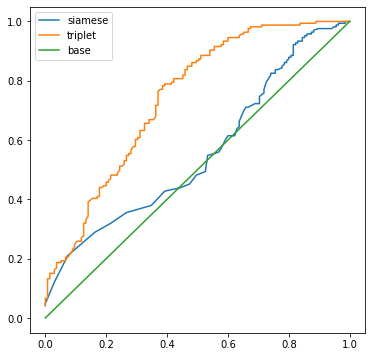

In [164]:
import matplotlib.pyplot as plt 
# TODO 32: calculate true positive rate and false positive rate 
# and plot both the ROC curve of siamese network and the ROC curve of triplet network 
# together with AUC score \
siamese_scores = siamese_scores.cpu()
triplet_scores = triplet_scores.cpu()
labels = torch.reshape(labels.cpu(), (-1,)).bool()
def get_RoC(scores, labels, t=0.5):
    tmp = torch.clone(scores)
    tmp[scores >= t] = 1
    tmp[scores <  t] = 0
    tmp = tmp.bool()
    TP = (tmp & labels).float().sum()
    FP = (tmp & ~labels).float().sum()
    FN = (~tmp & labels).float().sum()
    TN = (~tmp & ~labels).float().sum()
    return (TP/(TP+FN)), (FP/(FP+TN))

siamese_TPs = []
siamese_FPs = []
triplet_TPs = []
triplet_FPs = []
for t in torch.linspace(start=0, end=1, steps=5000):
    TPr, FPr = get_RoC(siamese_scores, labels, t)
    siamese_TPs.append(TPr.item())
    siamese_FPs.append(FPr.item())
    TPr, FPr = get_RoC(triplet_scores, labels, t)
    triplet_TPs.append(TPr.item())
    triplet_FPs.append(FPr.item())
plt.figure(figsize=(6, 6))
plt.plot(siamese_FPs, siamese_TPs)
plt.plot(triplet_FPs, triplet_TPs)
plt.plot((0,1), (0,1))
plt.legend(['siamese', 'triplet', 'base'])
plt.show()

In [185]:
siamese_data = np.array([[siamese_FPs[i], siamese_TPs[i]] for i in range(len(siamese_FPs))])
siamese_data = np.unique(siamese_data, axis=0)
triplet_data = np.array([[triplet_FPs[i], triplet_TPs[i]] for i in range(len(triplet_FPs))])
triplet_data = np.unique(triplet_data, axis=0)

In [186]:
siamese_AUC = 0
triplet_AUC = 0
for i in range(1, siamese_data.shape[0]):
    siamese_AUC += siamese_data[i,1] * (siamese_data[i,0] - siamese_data[i-1,0])
for i in range(1, triplet_data.shape[0]):
    triplet_AUC += triplet_data[i,1] * (triplet_data[i,0] - triplet_data[i-1,0])

In [187]:
siamese_AUC

0.5700580099269303

In [188]:
triplet_AUC

0.7424364122857997

The triplet model is better than the siamese model because it has more AUC score. 